# Data_Cleaning, Data_Engineering, Data_Visualizations

## Stock Prices Group

### 1. Libraries & Path Setup

**Explanation:** We define the paths using raw strings (r'...') to handle the backslashes in your Windows path correctly.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# Ensure output directory exists
os.makedirs(semi_clean_dir, exist_ok=True)
print("Directories set up successfully.")

Directories set up successfully.


### 2. Load the Backbone Dataset

**Explanation:** Loading the Master dataset and ensuring the 'date' column is actual datetime objects, not strings.

In [22]:
# Load the Backbone Data
file_path = os.path.join(raw_dir, "FINAL_THESIS_DATASET_CLEAN.csv")
df = pd.read_csv(file_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by Ticker and Date to ensure correct Rolling calculations
df = df.sort_values(by=['ticker', 'date'])

print(f"Data Loaded. Shape: {df.shape}")
print(f"Tickers present: {df['ticker'].unique()}")
df.head()

Data Loaded. Shape: (24648, 13)
Tickers present: ['COP' 'CVX' 'EOG' 'HAL' 'HES' 'OXY' 'XOM']


,date,volume,open,high,low,close,adj close,ticker,sentiment_score,n_articles,pos_avg,neg_avg,neu_avg
10562,2010-01-04,13880800.0,39.465130,40.158836,39.282173,40.082603,27.653933,COP,-0.407962,1.0,0.127206,0.535168,0.337626
10561,2010-01-05,10084500.0,40.135967,40.227444,39.800549,40.120720,27.680239,COP,0.000000,0.0,0.000000,0.000000,0.000000
10560,2010-01-06,11631900.0,40.151215,40.456139,39.892025,40.410400,27.880087,COP,0.000000,0.0,0.000000,0.000000,0.000000
10559,2010-01-07,7648900.0,40.181705,40.471386,40.021618,40.250313,27.769642,COP,0.000000,0.0,0.000000,0.000000,0.000000
10558,2010-01-08,7284200.0,40.105473,40.616226,39.968258,40.600979,28.011574,COP,0.000000,0.0,0.000000,0.000000,0.000000


### 3. Define Feature Engineering Functions

**Explanation:** This function calculates RSI and Log Returns. We wrap it in a function to keep the main logic clean.

**Note:** RSI calculation is a bit verbose because pandas doesn't have a built-in RSI function, so we write the standard formula manually.

In [25]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))

print("Feature Engineering functions defined.")

Feature Engineering functions defined.


### 4. Apply Transformations (The "Engine" Room)

**Explanation:** We use groupby('ticker') so that the Moving Average for XOM doesn't accidentally bleed into CVX.

**Critical:** We are using np.log for returns.

In [28]:
# Group by ticker to perform calculations per stock
# 1. Moving Averages
df['MA7'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=7).mean())
df['MA50'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=50).mean())

# 2. RSI (14-day standard)
df['RSI'] = df.groupby('ticker')['close'].transform(lambda x: calculate_rsi(x, period=14))

# 3. Log Returns (Log(Price_t / Price_t-1))
df['Log_Returns'] = df.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

# 4. Close / MA Ratios (Detrending features)
df['Close_to_MA7'] = df['close'] / df['MA7']
df['Close_to_MA50'] = df['close'] / df['MA50']

# Drop NaN values created by the rolling windows (first 50 days will be NaN)
df_clean_stock = df.dropna().copy()

print("Feature Engineering Complete.")
print(f"New Shape after dropping NaNs: {df_clean_stock.shape}")
df_clean_stock.head()

Feature Engineering Complete.
New Shape after dropping NaNs: (24255, 19)


,date,volume,open,high,low,close,adj close,ticker,sentiment_score,n_articles,pos_avg,neg_avg,neu_avg,MA7,MA50,RSI,Log_Returns,Close_to_MA7,Close_to_MA50
10513,2010-03-16,15411100.0,39.587097,39.869156,39.457504,39.770054,27.808268,COP,0.832790,1.0,0.876238,0.043448,0.080314,39.188516,38.402764,83.745506,0.010017,1.014840,1.035604
10512,2010-03-17,15822600.0,39.930141,40.539993,39.876778,40.387531,28.240026,COP,0.681747,2.0,0.712619,0.030872,0.256508,39.433546,38.408862,86.448540,0.015407,1.024192,1.051516
10511,2010-03-18,11119500.0,40.326546,40.334167,39.770054,40.181705,28.096098,COP,0.087004,4.0,0.297768,0.210764,0.491468,39.636105,38.410082,86.854394,-0.005109,1.013765,1.046124
10510,2010-03-19,15383600.0,39.922520,40.387531,39.411766,39.922520,27.914865,COP,-0.008735,1.0,0.042629,0.051364,0.906006,39.734117,38.400324,79.725051,-0.006471,1.004742,1.039640
10509,2010-03-22,10762700.0,39.213562,39.838665,39.137333,39.716694,27.770964,COP,0.018874,1.0,0.052015,0.033141,0.914844,39.821239,38.389652,72.589766,-0.005169,0.997375,1.034568


### 5. Save the Semi-Clean Dataset

**Explanation:** Saving this specific "Stock-Engineered" version into your semi-clean folder.

In [31]:
output_path = os.path.join(semi_clean_dir, "stock_engineered_1.csv")
df_clean_stock.to_csv(output_path, index=False)
print(f"Saved processed stock data to: {output_path}")

Saved processed stock data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\stock_engineered_1.csv


### 6. Visualization (7 Tickers, 7 Graphs)

**Explanation:** A loop that creates a dedicated figure for each ticker.

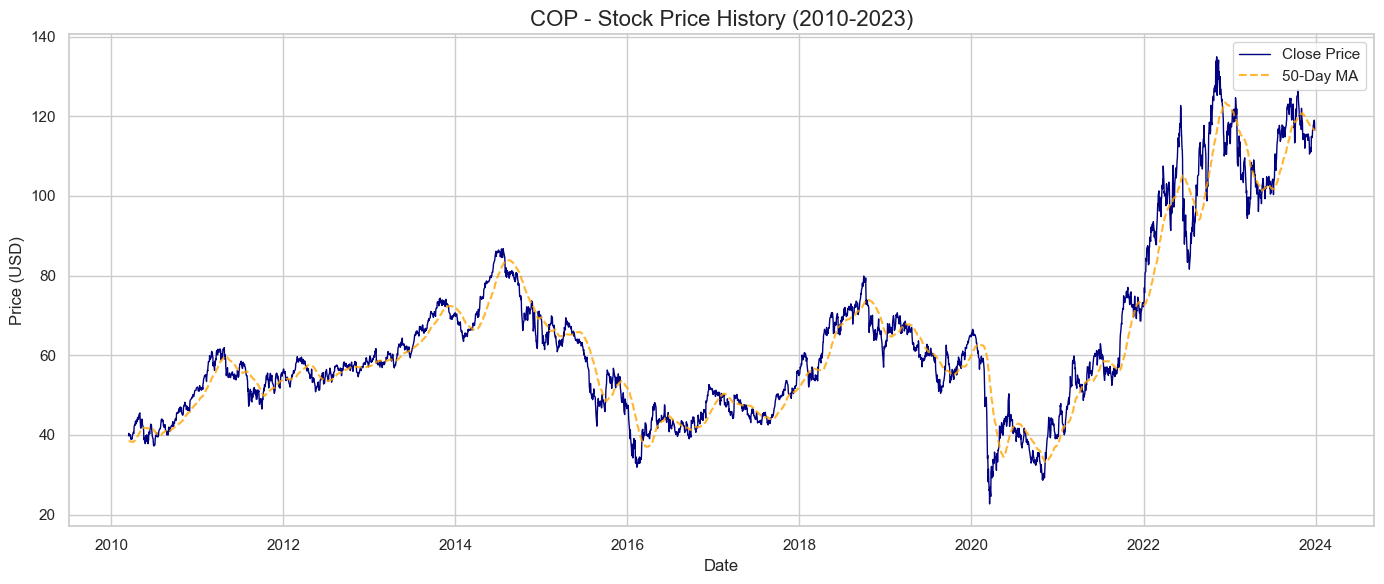

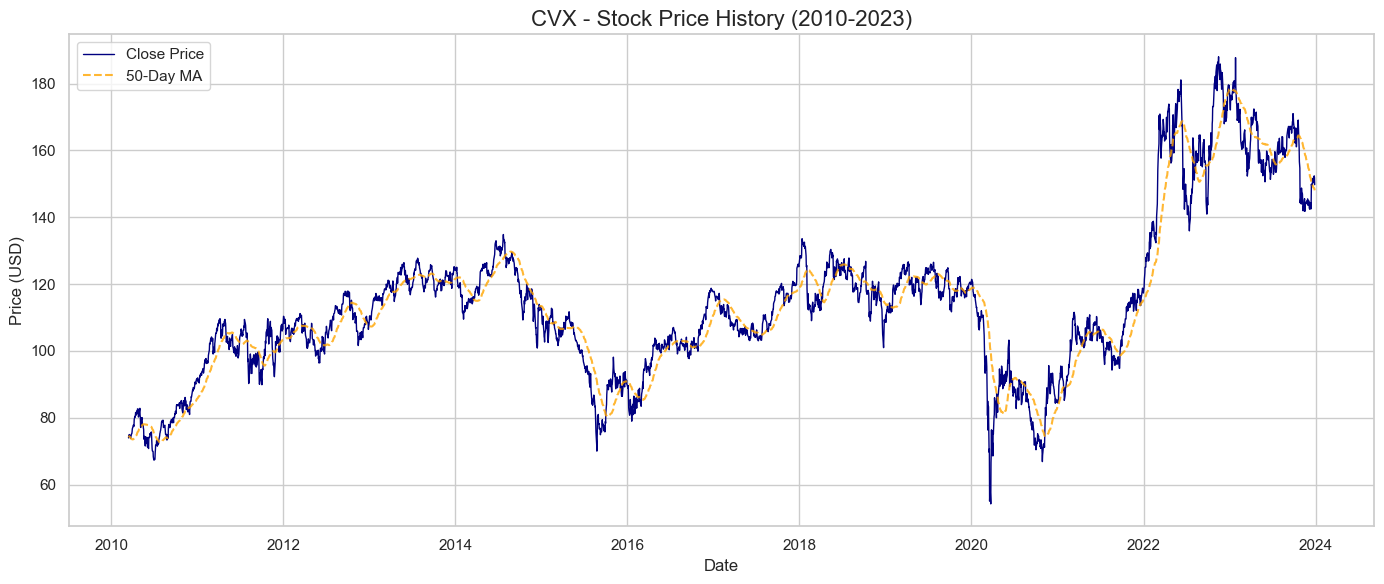

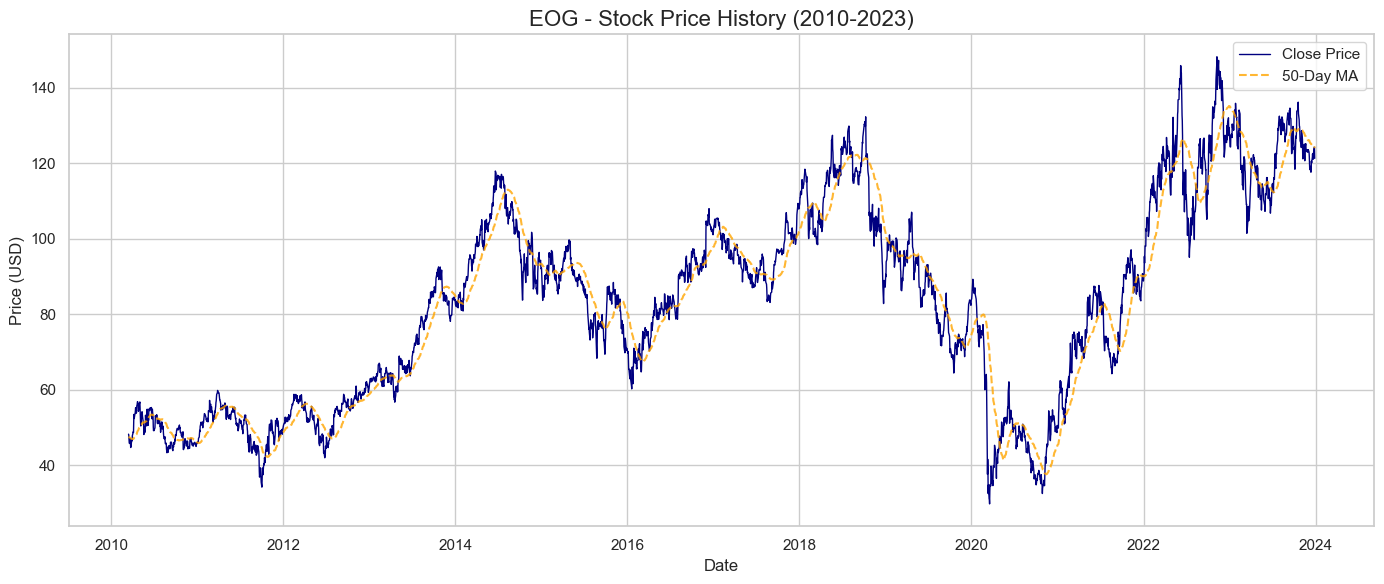

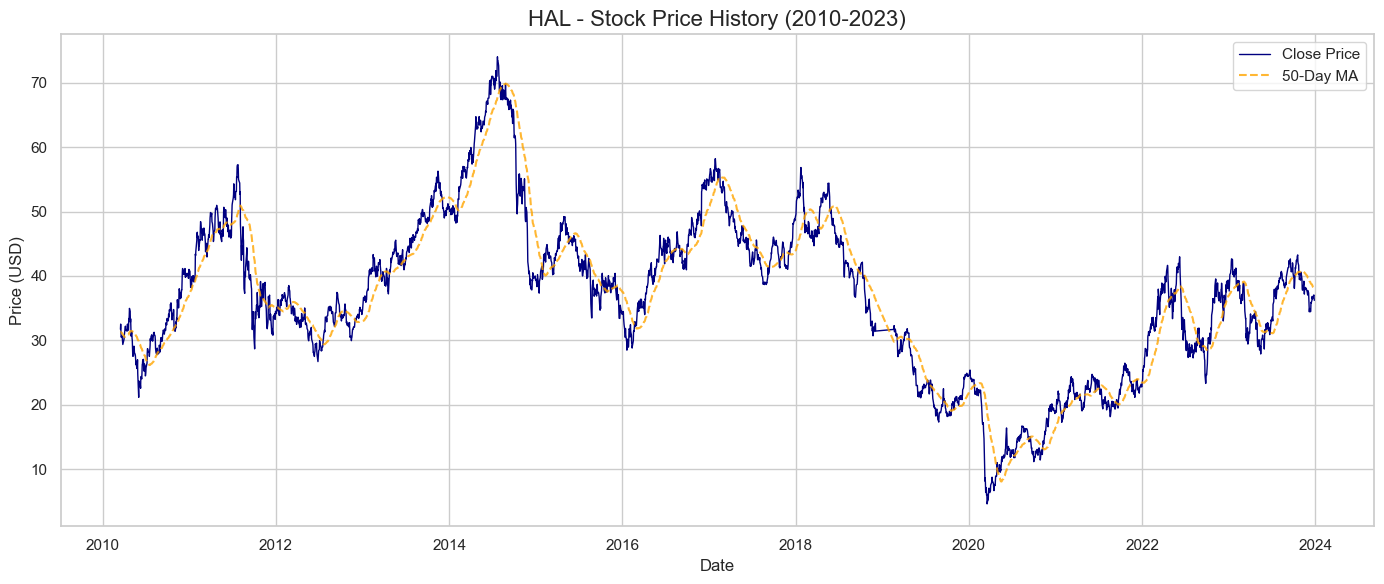

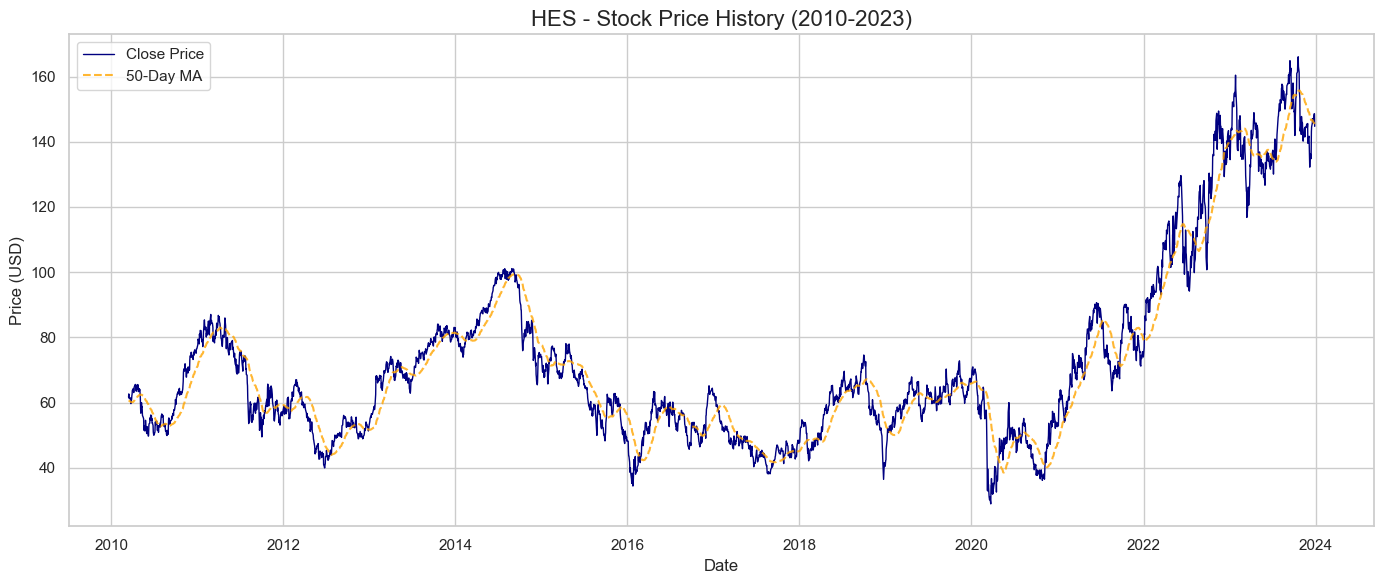

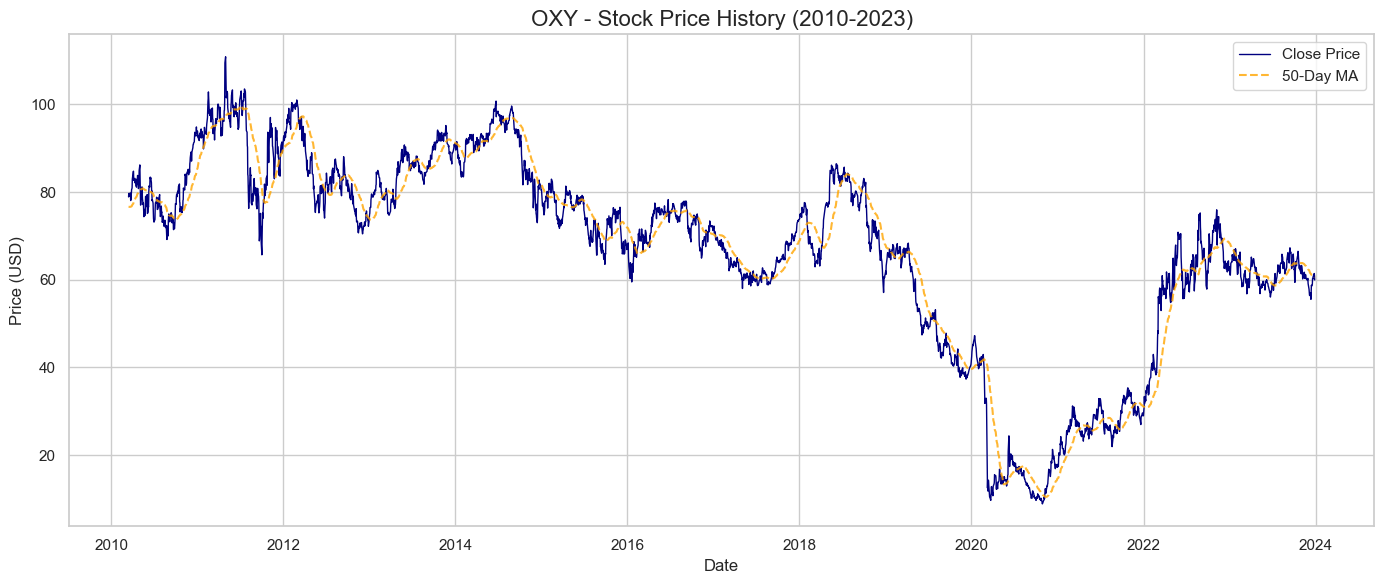

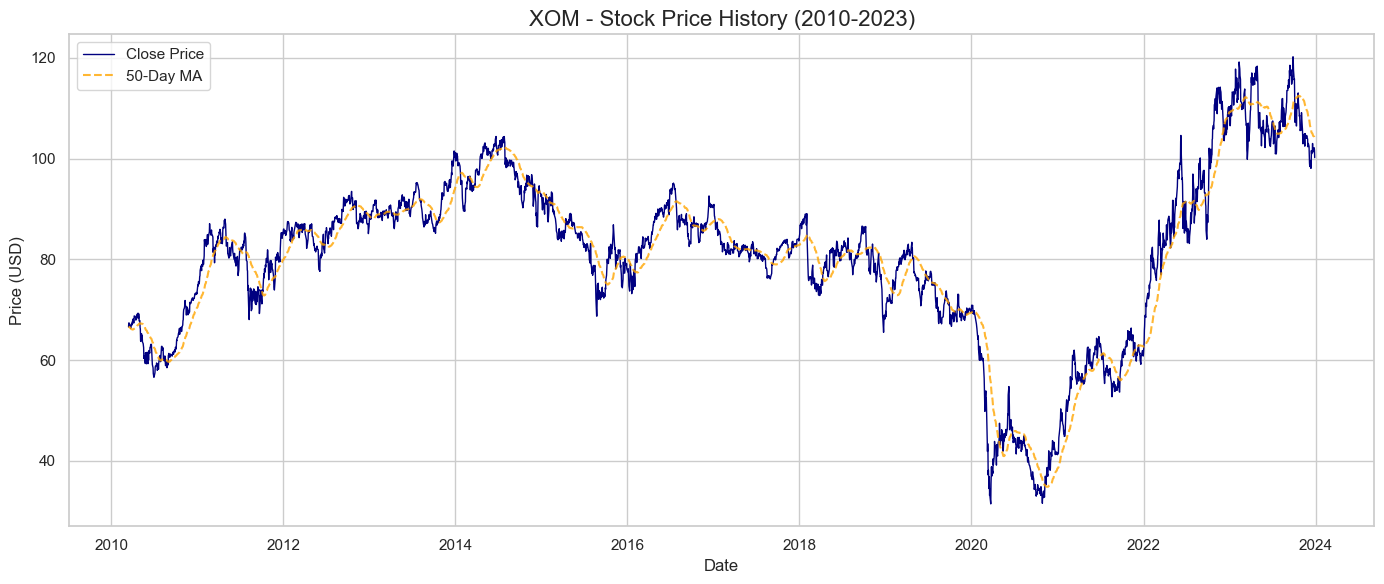

In [34]:
# Get list of unique tickers
tickers = df_clean_stock['ticker'].unique()

# Set plot style
sns.set(style="whitegrid")

for t in tickers:
    subset = df_clean_stock[df_clean_stock['ticker'] == t]
    
    plt.figure(figsize=(14, 6))
    plt.plot(subset['date'], subset['close'], label='Close Price', color='navy', linewidth=1)
    plt.plot(subset['date'], subset['MA50'], label='50-Day MA', color='orange', linestyle='--', alpha=0.8)
    
    plt.title(f"{t} - Stock Price History (2010-2023)", fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()